In [47]:
project_name = 'course-project-abstract-dcgan'

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!unzip "/content/drive/MyDrive/archive_2.zip"

Archive:  /content/drive/MyDrive/archive_2.zip
replace Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [50]:
!pip install opendatasets --upgrade --quiet

In [51]:
import opendatasets as od
import os

DATA_DIR = '/content/Abstract_gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery']


In [52]:
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])


['Abstract_image_172.jpg', 'Abstract_image_1561.jpg', 'Abstract_image_2432.jpg', 'Abstract_image_1516.jpg', 'Abstract_image_1210.jpg', 'Abstract_image_213.jpg', 'Abstract_image_1575.jpg', 'Abstract_image_469.jpg', 'Abstract_image_1173.jpg', 'Abstract_image_964.jpg']


In [53]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [54]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [55]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [56]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [58]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


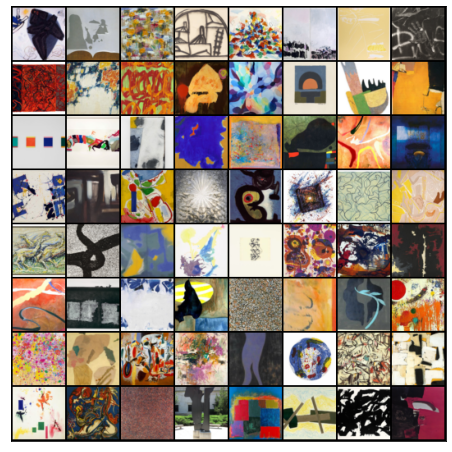

In [59]:
show_batch(train_dl)

In [60]:
!pip install jovian --upgrade --quiet

In [61]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [62]:
device = get_default_device()
device

device(type='cuda')

In [63]:
train_dl = DeviceDataLoader(train_dl, device)

In [64]:
import torch.nn as nn

In [65]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
)

In [66]:
discriminator = to_device(discriminator, device)

In [67]:
latent_size = 128

In [68]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


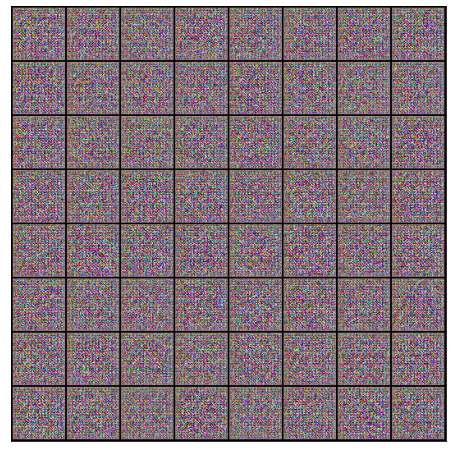

In [69]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [70]:
generator = to_device(generator, device)

In [71]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_score = -torch.mean(real_preds)

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_score = torch.mean(fake_preds)
    loss = real_score +fake_score
    loss.backward()
    opt_d.step()
    return loss.item(), real_score.item(), fake_score.item()

In [72]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    loss=-torch.mean(preds)

    loss.backward()
    opt_g.step()
    
    return loss.item()

In [73]:
from torchvision.utils import save_image

In [74]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [75]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [76]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


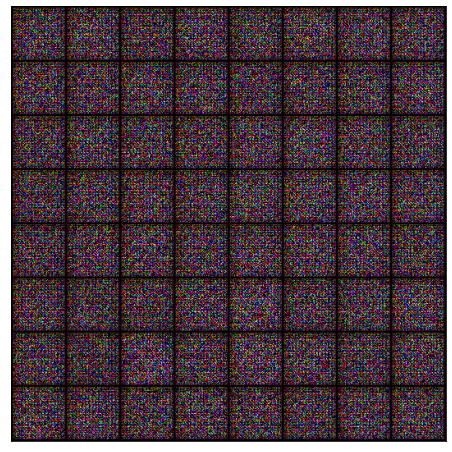

In [77]:
save_samples(0, fixed_latent)

In [78]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [79]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
          
            # Train discriminator
            for parm in discriminator.parameters():
              parm.data.clamp_(-0.01, 0.01)
            #Adding noise to data
            mean = 0.
            std = 10.
            noise = (torch.randn(real_images.shape) + mean) * std
            input = real_images + noise.cuda()
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [80]:
lr = 0.0001
epochs = 200

In [81]:
history = fit(epochs, lr)

  0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/200], loss_g: 0.0685, loss_d: -0.0806, real_score: -0.0591, fake_score: -0.0215
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 0.3173, loss_d: -0.3948, real_score: -0.2159, fake_score: -0.1788
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 0.3129, loss_d: -0.1764, real_score: -0.3927, fake_score: 0.2163
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 0.3497, loss_d: -0.5031, real_score: -0.3144, fake_score: -0.1887
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 0.4465, loss_d: -0.9075, real_score: -0.5303, fake_score: -0.3772
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 0.4655, loss_d: -0.9272, real_score: -0.5064, fake_score: -0.4208
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 0.3230, loss_d: -0.3585, real_score: -0.3259, fake_score: -0.0326
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 0.3180, loss_d: -0.5555, real_score: -0.2914, fake_score: -0.2640
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 0.3141, loss_d: -0.6335, real_score: -0.4402, fake_score: -0.1933
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 0.3872, loss_d: -0.7175, real_score: -0.3069, fake_score: -0.4107
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 0.5121, loss_d: -0.5034, real_score: -0.5875, fake_score: 0.0841
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 0.4089, loss_d: -0.3726, real_score: 0.0874, fake_score: -0.4600
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 0.5383, loss_d: -0.6897, real_score: -0.6277, fake_score: -0.0620
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 0.3952, loss_d: -0.9323, real_score: -0.4247, fake_score: -0.5076
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 0.4402, loss_d: -0.8357, real_score: -0.3223, fake_score: -0.5134
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 0.4786, loss_d: -0.7460, real_score: -0.5137, fake_score: -0.2323
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 0.4943, loss_d: -0.6742, real_score: -0.5090, fake_score: -0.1652
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 0.1507, loss_d: -0.0948, real_score: -0.5323, fake_score: 0.4376
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 0.1120, loss_d: -0.3535, real_score: -0.5753, fake_score: 0.2218
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/200], loss_g: -0.6354, loss_d: -0.0294, real_score: -0.6785, fake_score: 0.6491
Saving generated-images-0020.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 0.2974, loss_d: -0.6340, real_score: -0.1734, fake_score: -0.4606
Saving generated-images-0021.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 0.3213, loss_d: -0.3329, real_score: -0.0370, fake_score: -0.2958
Saving generated-images-0022.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 0.4497, loss_d: -0.9675, real_score: -0.4867, fake_score: -0.4809
Saving generated-images-0023.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 0.5393, loss_d: -0.9775, real_score: -0.6400, fake_score: -0.3375
Saving generated-images-0024.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 0.3310, loss_d: -0.4009, real_score: 0.0389, fake_score: -0.4399
Saving generated-images-0025.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 0.5125, loss_d: -0.8852, real_score: -0.5163, fake_score: -0.3689
Saving generated-images-0026.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 0.1184, loss_d: -0.3921, real_score: 0.0634, fake_score: -0.4555
Saving generated-images-0027.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 0.5083, loss_d: -0.6615, real_score: -0.5293, fake_score: -0.1322
Saving generated-images-0028.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 0.3107, loss_d: -0.8162, real_score: -0.3604, fake_score: -0.4558
Saving generated-images-0029.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 0.3538, loss_d: -0.7813, real_score: -0.3280, fake_score: -0.4533
Saving generated-images-0030.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 0.4944, loss_d: -0.2829, real_score: -0.3822, fake_score: 0.0993
Saving generated-images-0031.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 0.4191, loss_d: -0.4047, real_score: -0.3128, fake_score: -0.0919
Saving generated-images-0032.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 0.4157, loss_d: -0.1971, real_score: -0.0577, fake_score: -0.1394
Saving generated-images-0033.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 0.2899, loss_d: -0.1343, real_score: -0.0995, fake_score: -0.0348
Saving generated-images-0034.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 0.4837, loss_d: -0.6760, real_score: -0.5150, fake_score: -0.1610
Saving generated-images-0035.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 0.4241, loss_d: -0.6179, real_score: -0.4549, fake_score: -0.1630
Saving generated-images-0036.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 0.4610, loss_d: -0.5830, real_score: -0.4321, fake_score: -0.1509
Saving generated-images-0037.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 0.5453, loss_d: -0.6145, real_score: -0.4466, fake_score: -0.1679
Saving generated-images-0038.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 0.4230, loss_d: -0.5029, real_score: -0.3353, fake_score: -0.1676
Saving generated-images-0039.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 0.3375, loss_d: -0.4415, real_score: -0.2698, fake_score: -0.1718
Saving generated-images-0040.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 0.4956, loss_d: -0.4103, real_score: -0.5447, fake_score: 0.1344
Saving generated-images-0041.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 0.4310, loss_d: -0.4910, real_score: -0.5250, fake_score: 0.0340
Saving generated-images-0042.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 0.4412, loss_d: -0.5643, real_score: -0.4430, fake_score: -0.1213
Saving generated-images-0043.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 0.3535, loss_d: -0.3485, real_score: -0.3904, fake_score: 0.0419
Saving generated-images-0044.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 0.2943, loss_d: -0.3554, real_score: -0.2512, fake_score: -0.1042
Saving generated-images-0045.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 0.4023, loss_d: -0.3500, real_score: -0.2448, fake_score: -0.1052
Saving generated-images-0046.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 0.3384, loss_d: -0.6101, real_score: -0.3427, fake_score: -0.2674
Saving generated-images-0047.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 0.4424, loss_d: -0.4155, real_score: -0.3332, fake_score: -0.0823
Saving generated-images-0048.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 0.3504, loss_d: -0.5931, real_score: -0.3092, fake_score: -0.2840
Saving generated-images-0049.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 0.3665, loss_d: -0.2917, real_score: -0.3474, fake_score: 0.0556
Saving generated-images-0050.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 0.5111, loss_d: -0.6446, real_score: -0.4874, fake_score: -0.1572
Saving generated-images-0051.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 0.4037, loss_d: -0.6653, real_score: -0.3200, fake_score: -0.3453
Saving generated-images-0052.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 0.4640, loss_d: -0.4079, real_score: -0.4709, fake_score: 0.0630
Saving generated-images-0053.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 0.2136, loss_d: -0.5685, real_score: -0.2795, fake_score: -0.2889
Saving generated-images-0054.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 0.3614, loss_d: -0.4959, real_score: -0.3629, fake_score: -0.1330
Saving generated-images-0055.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 0.3615, loss_d: -0.6528, real_score: -0.3607, fake_score: -0.2921
Saving generated-images-0056.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 0.3806, loss_d: -0.4637, real_score: -0.4036, fake_score: -0.0602
Saving generated-images-0057.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 0.4715, loss_d: -0.4069, real_score: -0.4728, fake_score: 0.0659
Saving generated-images-0058.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 0.2292, loss_d: -0.6015, real_score: -0.1839, fake_score: -0.4176
Saving generated-images-0059.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 0.4368, loss_d: -0.5296, real_score: -0.3184, fake_score: -0.2112
Saving generated-images-0060.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 0.2615, loss_d: -0.3830, real_score: 0.0113, fake_score: -0.3944
Saving generated-images-0061.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 0.5090, loss_d: -0.8003, real_score: -0.5221, fake_score: -0.2782
Saving generated-images-0062.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 0.0093, loss_d: -0.5624, real_score: -0.1772, fake_score: -0.3852
Saving generated-images-0063.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 0.4213, loss_d: -0.3291, real_score: -0.5260, fake_score: 0.1969
Saving generated-images-0064.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 0.3468, loss_d: -0.1177, real_score: -0.3966, fake_score: 0.2789
Saving generated-images-0065.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 0.1798, loss_d: -0.3689, real_score: 0.1143, fake_score: -0.4832
Saving generated-images-0066.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 0.1975, loss_d: -0.3717, real_score: -0.2033, fake_score: -0.1685
Saving generated-images-0067.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 0.3001, loss_d: -0.4056, real_score: -0.3294, fake_score: -0.0762
Saving generated-images-0068.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 0.4291, loss_d: -0.3405, real_score: -0.2203, fake_score: -0.1202
Saving generated-images-0069.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 0.2858, loss_d: -0.2736, real_score: -0.0916, fake_score: -0.1820
Saving generated-images-0070.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 0.2943, loss_d: -0.2882, real_score: -0.4891, fake_score: 0.2009
Saving generated-images-0071.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 0.2889, loss_d: -0.4357, real_score: -0.1583, fake_score: -0.2774
Saving generated-images-0072.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 0.0734, loss_d: -0.4541, real_score: -0.0233, fake_score: -0.4308
Saving generated-images-0073.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 0.3538, loss_d: -0.3544, real_score: 0.1183, fake_score: -0.4728
Saving generated-images-0074.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 0.3784, loss_d: -0.4170, real_score: -0.3776, fake_score: -0.0394
Saving generated-images-0075.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 0.4263, loss_d: -0.4224, real_score: -0.4282, fake_score: 0.0058
Saving generated-images-0076.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 0.2534, loss_d: -0.5337, real_score: -0.1441, fake_score: -0.3895
Saving generated-images-0077.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 0.4795, loss_d: -0.5638, real_score: -0.5049, fake_score: -0.0589
Saving generated-images-0078.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 0.4344, loss_d: -0.4437, real_score: -0.3826, fake_score: -0.0611
Saving generated-images-0079.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.4026, loss_d: -0.5710, real_score: -0.3134, fake_score: -0.2576
Saving generated-images-0080.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 0.4983, loss_d: -0.6212, real_score: -0.3994, fake_score: -0.2218
Saving generated-images-0081.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 0.3817, loss_d: -0.7150, real_score: -0.3655, fake_score: -0.3495
Saving generated-images-0082.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 0.2839, loss_d: -0.4385, real_score: -0.1039, fake_score: -0.3346
Saving generated-images-0083.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 0.1455, loss_d: -0.4191, real_score: 0.0261, fake_score: -0.4452
Saving generated-images-0084.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 0.3286, loss_d: -0.3772, real_score: -0.1140, fake_score: -0.2632
Saving generated-images-0085.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 0.2222, loss_d: -0.5612, real_score: -0.1197, fake_score: -0.4415
Saving generated-images-0086.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 0.4731, loss_d: -0.5492, real_score: -0.1846, fake_score: -0.3646
Saving generated-images-0087.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [88/200], loss_g: -0.0136, loss_d: -0.3827, real_score: -0.0531, fake_score: -0.3296
Saving generated-images-0088.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 0.0670, loss_d: -0.3199, real_score: 0.0167, fake_score: -0.3366
Saving generated-images-0089.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 0.3570, loss_d: -0.4574, real_score: -0.4656, fake_score: 0.0082
Saving generated-images-0090.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 0.2530, loss_d: -0.5849, real_score: -0.1068, fake_score: -0.4781
Saving generated-images-0091.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 0.4894, loss_d: -0.3738, real_score: -0.4660, fake_score: 0.0922
Saving generated-images-0092.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 0.4871, loss_d: -0.5646, real_score: -0.4631, fake_score: -0.1014
Saving generated-images-0093.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 0.1982, loss_d: -0.6917, real_score: -0.3281, fake_score: -0.3637
Saving generated-images-0094.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 0.1547, loss_d: -0.5046, real_score: -0.0523, fake_score: -0.4524
Saving generated-images-0095.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [96/200], loss_g: -0.0063, loss_d: -0.5873, real_score: -0.2153, fake_score: -0.3720
Saving generated-images-0096.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 0.4881, loss_d: -0.6193, real_score: -0.3818, fake_score: -0.2375
Saving generated-images-0097.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 0.4367, loss_d: -0.5098, real_score: -0.5338, fake_score: 0.0240
Saving generated-images-0098.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 0.4042, loss_d: -0.5455, real_score: -0.2639, fake_score: -0.2816
Saving generated-images-0099.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 0.2294, loss_d: -0.5518, real_score: -0.0975, fake_score: -0.4543
Saving generated-images-0100.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 0.3362, loss_d: -0.5437, real_score: -0.2685, fake_score: -0.2752
Saving generated-images-0101.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 0.2933, loss_d: -0.6851, real_score: -0.3625, fake_score: -0.3226
Saving generated-images-0102.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 0.3780, loss_d: -0.6634, real_score: -0.2846, fake_score: -0.3789
Saving generated-images-0103.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 0.4089, loss_d: -0.5884, real_score: -0.3025, fake_score: -0.2859
Saving generated-images-0104.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 0.4850, loss_d: -0.7278, real_score: -0.5242, fake_score: -0.2036
Saving generated-images-0105.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 0.4791, loss_d: -0.5385, real_score: -0.4896, fake_score: -0.0489
Saving generated-images-0106.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 0.4026, loss_d: -0.6588, real_score: -0.4478, fake_score: -0.2110
Saving generated-images-0107.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.3701, loss_d: -0.3769, real_score: 0.1144, fake_score: -0.4913
Saving generated-images-0108.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 0.3664, loss_d: -0.7442, real_score: -0.4861, fake_score: -0.2581
Saving generated-images-0109.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 0.2443, loss_d: -0.5180, real_score: -0.2072, fake_score: -0.3108
Saving generated-images-0110.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 0.4269, loss_d: -0.4008, real_score: 0.0971, fake_score: -0.4979
Saving generated-images-0111.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 0.4359, loss_d: -0.6471, real_score: -0.4559, fake_score: -0.1912
Saving generated-images-0112.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 0.4136, loss_d: -0.7152, real_score: -0.4138, fake_score: -0.3014
Saving generated-images-0113.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 0.4936, loss_d: -0.3659, real_score: -0.5352, fake_score: 0.1693
Saving generated-images-0114.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 0.4622, loss_d: -0.7368, real_score: -0.4585, fake_score: -0.2784
Saving generated-images-0115.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 0.2893, loss_d: -0.6093, real_score: -0.2244, fake_score: -0.3849
Saving generated-images-0116.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [117/200], loss_g: -0.0416, loss_d: -0.4976, real_score: -0.0642, fake_score: -0.4334
Saving generated-images-0117.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 0.3083, loss_d: -0.7346, real_score: -0.4020, fake_score: -0.3326
Saving generated-images-0118.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 0.0870, loss_d: -0.6003, real_score: -0.2354, fake_score: -0.3648
Saving generated-images-0119.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 0.4049, loss_d: -0.7517, real_score: -0.4112, fake_score: -0.3405
Saving generated-images-0120.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 0.5087, loss_d: -0.6274, real_score: -0.5536, fake_score: -0.0738
Saving generated-images-0121.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [122/200], loss_g: -0.1730, loss_d: -0.5244, real_score: -0.1108, fake_score: -0.4136
Saving generated-images-0122.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 0.3033, loss_d: -0.4730, real_score: -0.0309, fake_score: -0.4421
Saving generated-images-0123.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 0.2069, loss_d: -0.5142, real_score: -0.0612, fake_score: -0.4531
Saving generated-images-0124.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 0.2739, loss_d: -0.7847, real_score: -0.3619, fake_score: -0.4228
Saving generated-images-0125.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 0.3397, loss_d: -0.6810, real_score: -0.3380, fake_score: -0.3430
Saving generated-images-0126.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 0.4238, loss_d: -0.6661, real_score: -0.4987, fake_score: -0.1673
Saving generated-images-0127.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 0.4077, loss_d: -0.7802, real_score: -0.4515, fake_score: -0.3288
Saving generated-images-0128.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 0.4168, loss_d: -0.3644, real_score: -0.4749, fake_score: 0.1106
Saving generated-images-0129.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 0.4133, loss_d: -0.4698, real_score: -0.2654, fake_score: -0.2044
Saving generated-images-0130.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 0.2208, loss_d: -0.7742, real_score: -0.3332, fake_score: -0.4410
Saving generated-images-0131.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 0.4185, loss_d: -0.6500, real_score: -0.4106, fake_score: -0.2395
Saving generated-images-0132.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 0.1668, loss_d: -0.7399, real_score: -0.3795, fake_score: -0.3604
Saving generated-images-0133.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 0.4104, loss_d: -0.6387, real_score: -0.4722, fake_score: -0.1664
Saving generated-images-0134.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 0.4199, loss_d: -0.9082, real_score: -0.5153, fake_score: -0.3929
Saving generated-images-0135.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 0.4492, loss_d: -0.6361, real_score: -0.4274, fake_score: -0.2086
Saving generated-images-0136.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 0.3248, loss_d: -0.5907, real_score: -0.1171, fake_score: -0.4736
Saving generated-images-0137.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [138/200], loss_g: -0.0118, loss_d: -0.6609, real_score: -0.2942, fake_score: -0.3667
Saving generated-images-0138.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 0.5226, loss_d: -0.6445, real_score: -0.5586, fake_score: -0.0858
Saving generated-images-0139.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 0.4492, loss_d: -0.6956, real_score: -0.5144, fake_score: -0.1813
Saving generated-images-0140.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 0.0627, loss_d: -0.5862, real_score: -0.1877, fake_score: -0.3985
Saving generated-images-0141.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 0.4533, loss_d: -0.8589, real_score: -0.5265, fake_score: -0.3323
Saving generated-images-0142.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 0.3792, loss_d: -0.2690, real_score: -0.5724, fake_score: 0.3033
Saving generated-images-0143.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 0.4135, loss_d: -0.7027, real_score: -0.3384, fake_score: -0.3642
Saving generated-images-0144.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 0.4392, loss_d: -0.6058, real_score: -0.5662, fake_score: -0.0396
Saving generated-images-0145.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [146/200], loss_g: -0.1641, loss_d: -0.5565, real_score: -0.1279, fake_score: -0.4287
Saving generated-images-0146.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 0.4490, loss_d: -0.8279, real_score: -0.5113, fake_score: -0.3166
Saving generated-images-0147.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 0.3786, loss_d: -0.3726, real_score: -0.6003, fake_score: 0.2277
Saving generated-images-0148.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 0.3998, loss_d: -0.7377, real_score: -0.4647, fake_score: -0.2730
Saving generated-images-0149.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 0.0030, loss_d: -0.6173, real_score: -0.2687, fake_score: -0.3487
Saving generated-images-0150.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 0.3385, loss_d: -0.7121, real_score: -0.3080, fake_score: -0.4041
Saving generated-images-0151.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 0.4489, loss_d: -0.7778, real_score: -0.5259, fake_score: -0.2519
Saving generated-images-0152.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 0.3233, loss_d: -0.7320, real_score: -0.4033, fake_score: -0.3287
Saving generated-images-0153.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 0.4899, loss_d: -0.6135, real_score: -0.4936, fake_score: -0.1199
Saving generated-images-0154.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [155/200], loss_g: -0.0358, loss_d: -0.6135, real_score: -0.1758, fake_score: -0.4377
Saving generated-images-0155.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 0.3699, loss_d: -0.3294, real_score: 0.1528, fake_score: -0.4822
Saving generated-images-0156.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 0.5054, loss_d: -0.6521, real_score: -0.5712, fake_score: -0.0809
Saving generated-images-0157.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 0.5204, loss_d: -0.5341, real_score: -0.5931, fake_score: 0.0590
Saving generated-images-0158.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 0.0157, loss_d: -0.4245, real_score: 0.0177, fake_score: -0.4422
Saving generated-images-0159.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 0.3166, loss_d: -0.8323, real_score: -0.4606, fake_score: -0.3717
Saving generated-images-0160.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 0.4546, loss_d: -0.8377, real_score: -0.5541, fake_score: -0.2836
Saving generated-images-0161.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 0.2474, loss_d: -0.6581, real_score: -0.2094, fake_score: -0.4488
Saving generated-images-0162.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 0.2467, loss_d: -0.7013, real_score: -0.3163, fake_score: -0.3850
Saving generated-images-0163.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 0.1291, loss_d: -0.5152, real_score: -0.1805, fake_score: -0.3347
Saving generated-images-0164.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 0.4031, loss_d: -0.6660, real_score: -0.4451, fake_score: -0.2209
Saving generated-images-0165.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 0.3275, loss_d: -0.7464, real_score: -0.3670, fake_score: -0.3794
Saving generated-images-0166.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 0.3746, loss_d: -0.6328, real_score: -0.4193, fake_score: -0.2135
Saving generated-images-0167.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 0.4261, loss_d: -0.5756, real_score: -0.5337, fake_score: -0.0419
Saving generated-images-0168.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [169/200], loss_g: -0.0547, loss_d: -0.4928, real_score: -0.0402, fake_score: -0.4526
Saving generated-images-0169.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 0.2527, loss_d: -0.5261, real_score: -0.1377, fake_score: -0.3884
Saving generated-images-0170.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 0.4207, loss_d: -0.8099, real_score: -0.4773, fake_score: -0.3326
Saving generated-images-0171.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 0.4960, loss_d: -0.6355, real_score: -0.5040, fake_score: -0.1315
Saving generated-images-0172.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 0.3374, loss_d: -0.6896, real_score: -0.4626, fake_score: -0.2270
Saving generated-images-0173.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 0.0021, loss_d: -0.5266, real_score: -0.0563, fake_score: -0.4703
Saving generated-images-0174.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 0.3370, loss_d: -0.6978, real_score: -0.4625, fake_score: -0.2354
Saving generated-images-0175.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 0.3716, loss_d: -0.7192, real_score: -0.4779, fake_score: -0.2413
Saving generated-images-0176.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 0.4088, loss_d: -0.6925, real_score: -0.4616, fake_score: -0.2309
Saving generated-images-0177.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 0.3986, loss_d: -0.6546, real_score: -0.4487, fake_score: -0.2059
Saving generated-images-0178.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 0.2986, loss_d: -0.6663, real_score: -0.2519, fake_score: -0.4144
Saving generated-images-0179.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 0.3770, loss_d: -0.7696, real_score: -0.4489, fake_score: -0.3208
Saving generated-images-0180.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 0.3276, loss_d: -0.6963, real_score: -0.4344, fake_score: -0.2619
Saving generated-images-0181.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 0.3433, loss_d: -0.7001, real_score: -0.3396, fake_score: -0.3606
Saving generated-images-0182.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 0.2762, loss_d: -0.7799, real_score: -0.3871, fake_score: -0.3929
Saving generated-images-0183.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 0.4317, loss_d: -0.5962, real_score: -0.4576, fake_score: -0.1386
Saving generated-images-0184.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 0.3579, loss_d: -0.7090, real_score: -0.3983, fake_score: -0.3107
Saving generated-images-0185.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 0.3830, loss_d: -0.5784, real_score: -0.4185, fake_score: -0.1599
Saving generated-images-0186.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 0.2308, loss_d: -0.6843, real_score: -0.3158, fake_score: -0.3685
Saving generated-images-0187.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 0.1852, loss_d: -0.5185, real_score: -0.0776, fake_score: -0.4408
Saving generated-images-0188.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 0.4916, loss_d: -0.5674, real_score: -0.5375, fake_score: -0.0299
Saving generated-images-0189.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 0.2754, loss_d: -0.6184, real_score: -0.1779, fake_score: -0.4404
Saving generated-images-0190.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 0.3084, loss_d: -0.6679, real_score: -0.3136, fake_score: -0.3543
Saving generated-images-0191.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 0.4231, loss_d: -0.6169, real_score: -0.4725, fake_score: -0.1444
Saving generated-images-0192.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 0.1755, loss_d: -0.5278, real_score: -0.1338, fake_score: -0.3940
Saving generated-images-0193.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 0.3153, loss_d: -0.7251, real_score: -0.3290, fake_score: -0.3961
Saving generated-images-0194.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 0.3029, loss_d: -0.5833, real_score: -0.2856, fake_score: -0.2977
Saving generated-images-0195.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 0.3044, loss_d: -0.7055, real_score: -0.3292, fake_score: -0.3762
Saving generated-images-0196.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 0.4963, loss_d: -0.6077, real_score: -0.5228, fake_score: -0.0849
Saving generated-images-0197.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 0.3374, loss_d: -0.7468, real_score: -0.4120, fake_score: -0.3348
Saving generated-images-0198.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 0.2768, loss_d: -0.5974, real_score: -0.3176, fake_score: -0.2798
Saving generated-images-0199.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 0.4279, loss_d: -0.6859, real_score: -0.4794, fake_score: -0.2065
Saving generated-images-0200.png


In [82]:
losses_g, losses_d, real_scores, fake_scores = history

In [83]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [84]:
from IPython.display import Image

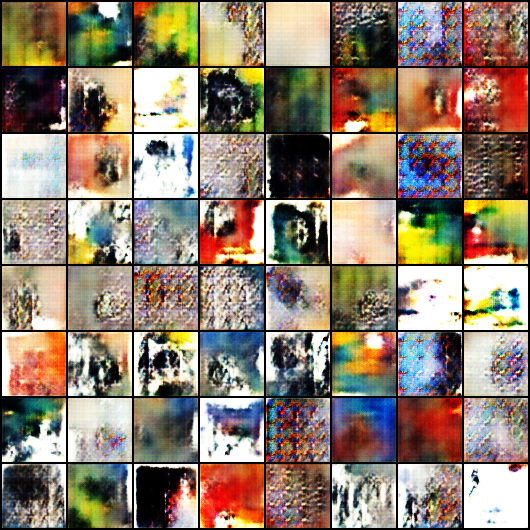

In [100]:
Image('./generated/generated-images-0175.png')

In [86]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [87]:
type(real_scores)

list

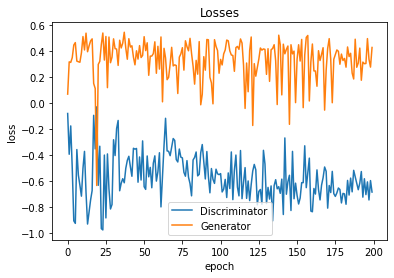

In [88]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

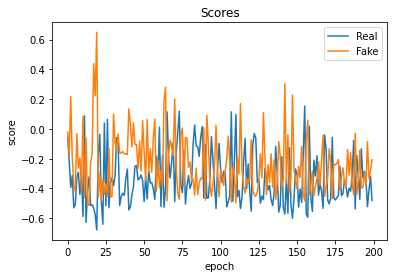

In [89]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');